In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math,os
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [3]:

def create_dataset(dataset, look_back=1):  # 后一个数据和前look_back个数据有关系
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)  # .apeend方法追加元素
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)  # 生成输入数据和输出数据


def cal_the_return(testPredict,testY):
    # 测试集的实际收益率和测试集的预测收益率
    compare=pd.DataFrame({'pred_y':testPredict.T[0],'real_y':testY.T[0]})
    # 计算转债累计收益率
    accy=(compare['real_y']/100+1).cumprod()
    # 计算策略累计收益率
    accp=(pd.Series(compare['real_y'][compare['pred_y']>0],index=compare.index).fillna(0)/100+1).cumprod()

    compare['acc_y'] = accy # 累计收益率真实值
    compare['acc_p'] = accp # 预测累计收益率
    return compare


def data_processing_xgb(price_series,look_back):
    # 转换为收益率序列
    pct_chg_series=(price_series/price_series.shift(1)-1)[1:]

    # 进行归一化
    scaler = MinMaxScaler(feature_range=(0, 1))  # 定义归一化函数，归一化0-1
    scaler_series=scaler.fit_transform(np.array(pct_chg_series*100).reshape(len(pct_chg_series),1))
    train,test=scaler_series[0:int(len(scaler_series)*0.7)],scaler_series[int(len(scaler_series)*0.7):] # 对其进行训练和测试的划分
    
    # 对于训练集和测试集按照所需格式进行划分
    train_x,train_y=create_dataset(train,look_back=20) # 训练集
    test_x,test_y=create_dataset(test,look_back=20) # 测试集

    # 进行reshape，用于XGBoosting模型
    train_x=np.reshape(train_x, (train_x.shape[0], train_x.shape[1]))
    test_x=np.reshape(test_x, (test_x.shape[0], test_x.shape[1]))
    return train_x,train_y,test_x,test_y,scaler
    
    
def xgb_model(price_series):
    assert type(price_series)==type(pd.Series(dtype='float')),'请传入价格的pandas Series序列'
    
    look_back=20
    train_x,train_y,test_x,test_y,scaler=data_processing_xgb(price_series,look_back)
    dtrain = xgb.DMatrix(train_x, label = train_y)
    dtest = xgb.DMatrix(test_x)
    # 参数设置
    params={'booster':'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth':4,
        'lambda':10,
        'subsample':0.75,
        'colsample_bytree':0.75,
        'min_child_weight':2,
        'eta': 0.025,
        'seed':0,
        'nthread':8,
         'silent':1}

    watchlist = [(dtrain,'train')]
    # 进行训练
    bst=xgb.train(params,dtrain,num_boost_round=1000,evals=watchlist,verbose_eval=100)
    # 预测
    test_predict=bst.predict(dtest)
    # 反归一化
    test_predict=scaler.inverse_transform(test_predict.reshape(len(test_predict),1))# 需要reshape一下，以便inverse_transform
    test_y=scaler.inverse_transform(test_y)
    # 进行策略对比
    compare=cal_the_return(test_predict,test_y)
    # print(compare)
    return compare,bst

[16:30:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50412
[100]	train-auc:0.53154
[200]	train-auc:0.54588
[300]	train-auc:0.55148
[400]	train-auc:0.55421
[500]	train-auc:0.55610
[600]	train-auc:0.55740
[700]	train-auc:0.55827
[800]	train-auc:0.55890
[900]	train-auc:0.55942
[999]	train-auc:0.55978


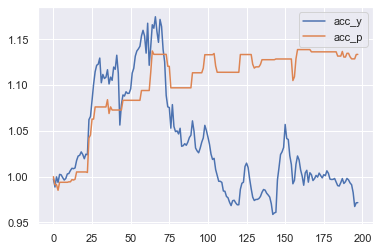

In [4]:
df=pd.read_excel('转债时间序列.xlsx',index_col=0)[:-7]
price_series=df['110031.SH']
compare,bst=xgb_model(price_series)
compare.iloc[:,2:].plot()

## 第二个模型

In [5]:
price_series=df.iloc[:,1]
look_back=20
train_x,train_y,test_x,test_y,scaler=data_processing_xgb(price_series,look_back)
dtrain = xgb.DMatrix(train_x, label = train_y)
dtest = xgb.DMatrix(test_x)

In [6]:
price_series

2017-09-18    125.2293
2017-09-19    124.5082
2017-09-20    125.0671
2017-09-21    124.8260
2017-09-22    123.9149
                ...   
2020-09-09    112.9567
2020-09-10    112.7923
2020-09-11    111.1679
2020-09-14    111.8848
2020-09-15    112.1304
Name: 110034.SH, Length: 729, dtype: float64

In [7]:
(price_series/price_series.shift(1)-1)[1:]

2017-09-19   -0.005758
2017-09-20    0.004489
2017-09-21   -0.001928
2017-09-22   -0.007299
2017-09-25   -0.007532
                ...   
2020-09-09   -0.005235
2020-09-10   -0.001455
2020-09-11   -0.014402
2020-09-14    0.006449
2020-09-15    0.002195
Name: 110034.SH, Length: 728, dtype: float64

In [8]:
# 参数设置
params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1}

watchlist = [(dtrain,'train')]

bst=xgb.train(params,dtrain,num_boost_round=1000,evals=watchlist,verbose_eval=100,xgb_model=bst)
pred_y=bst.predict(dtest)


[16:30:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50551
[100]	train-auc:0.54719
[200]	train-auc:0.56290
[300]	train-auc:0.56953
[400]	train-auc:0.57323
[500]	train-auc:0.57575
[600]	train-auc:0.57769
[700]	train-auc:0.57911
[800]	train-auc:0.58018
[900]	train-auc:0.58096
[999]	train-auc:0.58156


pred_y    0.190912
real_y    0.644880
acc_y     1.060960
acc_p     1.208375
Name: 197, dtype: float64


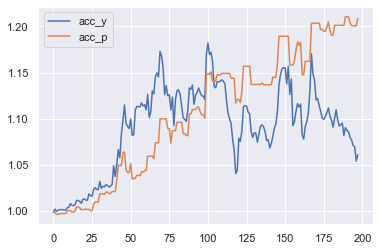

In [9]:
# 反归一化
# train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(pred_y.reshape(len(pred_y),1))
test_y0=scaler.inverse_transform(test_y)
# 进行策略对比
compare=cal_the_return(test_predict,test_y0)
print(compare.iloc[-1])
compare.iloc[:,2:].plot()

In [12]:
scaler.inverse_transform(np.array([0.5]).reshape(-1, 1))

array([[-0.44617207]])

In [13]:
a=np.array([[[1]]])
a

array([[[1]]])

In [14]:
a.shape

(1, 1, 1)

In [15]:
a.reshape(1,-1)

array([[1]])

In [16]:
a.shape

(1, 1, 1)